In [1]:
# env sctk2

%load_ext autoreload
%autoreload 2

import os, re, gc 
#joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.pyplot import rc_context
import seaborn as sn
import anndata
import scanpy as sc
#import scvelo as scv
import sctk as sk
#import cellrank as cr

rcParams["pdf.fonttype"] = 42
rcParams["ps.fonttype"] = 42
expr_cmap = sk.expression_colormap()
np.set_printoptions(linewidth=150)

import numpy_groupies as npg
#from plotnine import ggplot, aes
#import plotnine as pln
from matplotlib.colors import ListedColormap

import matplotlib
import matplotlib.cm as cm

from statsmodels.stats.multitest import fdrcorrection

from scipy.stats import pearsonr, spearmanr

import scipy.sparse as sp

In [2]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

scanpy==1.9.3 anndata==0.8.0 umap==0.5.1 numpy==1.23.4 scipy==1.9.3 pandas==1.5.1 scikit-learn==1.1.3 statsmodels==0.13.5 python-igraph==0.10.4 pynndescent==0.5.8


In [3]:
#load data object: prenatal skin only, post qc

data_root_path = '/home/jovyan/mount_farm/nfs/nfs/team298/hg6/Fetal_skin/data/final/'
panimmune_path= data_root_path + 'pan_immune.h5ad'
pdata = sc.read(panimmune_path)

# Check data and annotations

In [4]:
pdata

AnnData object with n_obs × n_vars = 318670 × 33538
    obs: 'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation'
    var: 'GeneID', 'GeneName', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'scvi_model_var'
    uns: 'scvi'
    obsm: 'X_scvi', 'X_umap'
    obsp: 'scvi_connectivities', 'scvi_distances'

In [5]:
print(list(pdata.obs['anno_lvl_2_final_clean'].unique()))

['DOUBLET_IMMUNE_FIBROBLAST', 'ENDOTHELIUM_I', 'VSMC_PERICYTE', 'ENDOTHELIUM_II', 'CYCLING_FIBROBLAST_I', 'FIBROBLAST_I', 'MACROPHAGE_PERI', 'MELANOCYTE', 'MYOFIBROBLAST', 'FIBROBLAST_II', 'CYCLING_FIBROBLAST_II', 'KERATINOCYTE', 'FIBROBLAST_III', 'FIBROBLAST_IV', 'GLIAL', 'LOW_QUALITY', 'FIBROBLAST_V', 'ENDOTHELIUM_III', 'DOUBLET_ENDOTHELIUM_ERYTHROCYTE', 'ENDOTHELIUM_IV', 'MESOTHELIUM', 'FIBROBLAST_VI', 'FIBROBLAST_VII', 'FIBROBLAST_VIII', 'VSMC_PERICYTE_I', 'FIBROBLAST_IX', 'SMOOTH_MUSCLE', 'NEURON', 'FIBROBLAST_X', 'HEPATOCYTE-LIKE', 'YS_STROMA', 'nan', 'FIBROBLAST_XI', 'HEPATOCYTE_I', 'HEPATOCYTE_II', 'EPITHELIUM_I', 'CYCLING_EPITHELIUM', 'EPITHELIUM_II', 'DEVELOPING_NEPHRON_I', 'DEVELOPING_NEPHRON_II', 'ENTEROENDOCRINE_I', 'MYOFIBROBLAST_I', 'FIBROBLAST_XII', 'INTERSTITIAL_CELLS_OF_CAJAL', 'VSMC_PERICYTE_II', 'MESENCHYMAL_LYMPHOID_TISSUE_ORGANISER', 'ENTEROENDOCRINE_II', 'FIBROBLAST_XIII', 'FIBROBLAST_XIV', 'FIBROBLAST_XV', 'MUSCLE_SATELLITE', 'OSTEOBLAST', 'ENDOTHELIUM_V', 'SKEL

In [6]:
print(list(pdata.obs['organ'].unique()))

['SK', 'SP', 'YS', 'LI', 'TH', 'GU', 'BM', 'KI', 'MLN']


In [7]:
print(list(pdata.obs['age'].unique()))

[12, 14, 4, 11, 13, 16, 15, 17, 9, 7, 8, 10]


In [8]:
print(list(pdata.obs['donor'].unique()))

['F45', 'F51', 'F37', 'F23', 'F30', 'F38', 'F41', 'F73', 'F78', 'F66', 'F29', 'F69', 'F33', 'F61', 'F22', 'F71', 'F34', 'F35', 'F72', 'F67', 'F50', 'F21', 'F32', 'F19', 'F64']


# Log-norm data and re-name FRZB gene by organ

In [9]:
sc.pp.normalize_total(pdata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:02)


In [10]:
sc.pp.log1p(pdata)

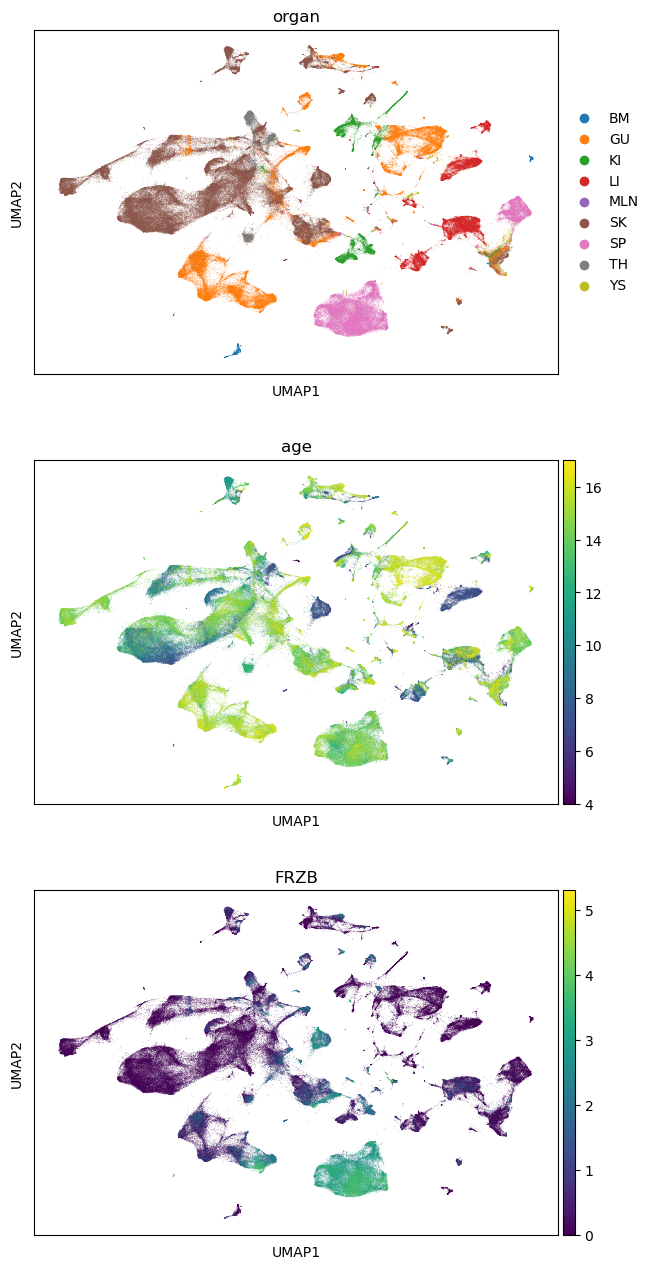

In [11]:
sc.pl.umap(pdata, color=['organ', 'age', 'FRZB'], ncols=1)

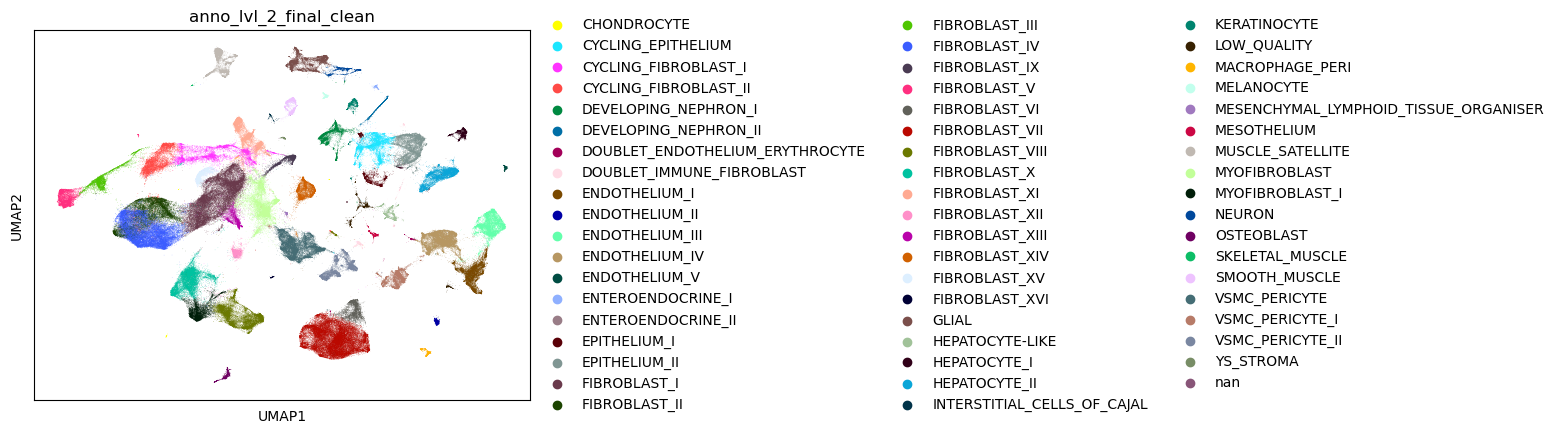

In [12]:
sc.pl.umap(pdata, color=['anno_lvl_2_final_clean'], ncols=1)

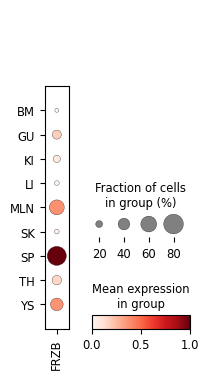

In [13]:
sc.pl.dotplot(pdata, var_names=['FRZB'], groupby='organ', standard_scale='var')
#return_fig=True).savefig('/home/jovyan/projects/skin/fetal_skin/figures/marker_panels/fetal_inflammgenes_270622.pdf')

In [14]:
pdata.obs['pcw_cat'] = pdata.obs['age'].astype('category')

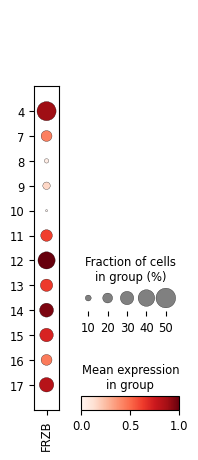

In [15]:
sc.pl.dotplot(pdata, var_names=['FRZB'], groupby='pcw_cat', standard_scale='var')

In [16]:
pdata.obs

,n_counts,n_genes,file,mito,doublet_scores,predicted_doublets,old_annotation_uniform,organ,Sort_id,age,method,donor,sex,Sample,scvi_clusters,is_maternal_contaminant,anno_lvl_2_final_clean,celltype_annotation,pcw_cat
index,,,,,,,,,,,,,,,,,,,
FCAImmP7579224-GGGTTGCAGAAGGGTA,40400.0,5581,FCAImmP7579224,0.025025,0.326203,False,nan,SK,CD45P,12,5GEX,F45,female,F45_SK_CD45P_FCAImmP7579224,40,False,DOUBLET_IMMUNE_FIBROBLAST,DOUBLET_IMMUNE_FIBROBLAST,12
FCAImmP7579224-GACTGCGTCTTGGGTA,39517.0,5648,FCAImmP7579224,0.045348,0.243697,False,nan,SK,CD45P,12,5GEX,F45,female,F45_SK_CD45P_FCAImmP7579224,11,False,ENDOTHELIUM_I,ENDOTHELIUM_I,12
FCAImmP7579224-ATCATGGTCAAGAAGT,31472.0,5207,FCAImmP7579224,0.030122,0.117647,False,nan,SK,CD45P,12,5GEX,F45,female,F45_SK_CD45P_FCAImmP7579224,3,False,VSMC_PERICYTE,VSMC_PERICYTE,12
FCAImmP7579224-ACGGCCACACAACTGT,28336.0,5495,FCAImmP7579224,0.035044,0.164087,False,nan,SK,CD45P,12,5GEX,F45,female,F45_SK_CD45P_FCAImmP7579224,3,False,VSMC_PERICYTE,VSMC_PERICYTE,12
FCAImmP7579224-GAAACTCAGGCTCATT,25563.0,5513,FCAImmP7579224,0.034542,0.176471,False,nan,SK,CD45P,12,5GEX,F45,female,F45_SK_CD45P_FCAImmP7579224,42,False,ENDOTHELIUM_II,ENDOTHELIUM_II,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FCAImmP7803042-AGTGGGAGTCGACTGC,2015.0,865,FCAImmP7803042,0.032258,0.057283,False,nan,SK,CD45N,14,5GEX,F51,female,F51_SK_CD45N_FCAImmP7803042,29,False,FIBROBLAST_XIII,FIBROBLAST_XIII,14
FCAImmP7803042-CCATTCGTCAACACAC,2013.0,1095,FCAImmP7803042,0.034277,0.019263,False,FIBROBLAST,SK,CD45N,14,5GEX,F51,female,F51_SK_CD45N_FCAImmP7803042,22,False,FIBROBLAST_V,FIBROBLAST_V,14
FCAImmP7803042-CGTAGCGAGTGACATA,2011.0,789,FCAImmP7803042,0.073098,0.098999,False,nan,SK,CD45N,14,5GEX,F51,female,F51_SK_CD45N_FCAImmP7803042,1,False,FIBROBLAST_I,FIBROBLAST_I,14


In [17]:
organ_keep1 = ['SK']
pdata_skin = pdata[pdata.obs['organ'].isin(organ_keep1)]
pdata_skin.var.rename(index={'FRZB':'FRZB_skin'},inplace=True)
pdata_skin

View of AnnData object with n_obs × n_vars = 127562 × 33538
    obs: 'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation', 'pcw_cat'
    var: 'GeneID', 'GeneName', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'scvi_model_var'
    uns: 'scvi', 'log1p', 'organ_colors', 'anno_lvl_2_final_clean_colors'
    obsm: 'X_scvi', 'X_umap'
    obsp: 'scvi_connectivities', 'scvi_distances'

In [18]:
#organs = ['SP', 'YS', 'LI', 'TH', 'GU', 'BM', 'KI', 'MLN']
#import anndata as ad
#pdata2_all = pdata2_skin
#for i in organs:
#    organ_keep = [i]
#    pdata2_organ = pdata2[pdata2.obs['organ'].isin(organ_keep)]
#    pdata2_organ.var.rename(index={'FRZB':'FRZB' + i},inplace=True)
#    pdata2_all = ad.concat([pdata2_all, pdata2_organ], join='outer')

In [19]:
organ_keep2 = ['SP']
pdata_spleen = pdata[pdata.obs['organ'].isin(organ_keep2)]
pdata_spleen.var.rename(index={'FRZB':'FRZB_spleen'},inplace=True)
pdata_spleen

View of AnnData object with n_obs × n_vars = 46754 × 33538
    obs: 'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation', 'pcw_cat'
    var: 'GeneID', 'GeneName', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'scvi_model_var'
    uns: 'scvi', 'log1p', 'organ_colors', 'anno_lvl_2_final_clean_colors'
    obsm: 'X_scvi', 'X_umap'
    obsp: 'scvi_connectivities', 'scvi_distances'

In [20]:
organ_keep3 = ['YS']
pdata_yolksac = pdata[pdata.obs['organ'].isin(organ_keep3)]
pdata_yolksac.var.rename(index={'FRZB':'FRZB_yolksac'},inplace=True)
pdata_yolksac

View of AnnData object with n_obs × n_vars = 3561 × 33538
    obs: 'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation', 'pcw_cat'
    var: 'GeneID', 'GeneName', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'scvi_model_var'
    uns: 'scvi', 'log1p', 'organ_colors', 'anno_lvl_2_final_clean_colors'
    obsm: 'X_scvi', 'X_umap'
    obsp: 'scvi_connectivities', 'scvi_distances'

In [21]:
organ_keep4 = ['LI']
pdata_liver = pdata[pdata.obs['organ'].isin(organ_keep4)]
pdata_liver.var.rename(index={'FRZB':'FRZB_liver'},inplace=True)
pdata_liver

View of AnnData object with n_obs × n_vars = 31884 × 33538
    obs: 'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation', 'pcw_cat'
    var: 'GeneID', 'GeneName', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'scvi_model_var'
    uns: 'scvi', 'log1p', 'organ_colors', 'anno_lvl_2_final_clean_colors'
    obsm: 'X_scvi', 'X_umap'
    obsp: 'scvi_connectivities', 'scvi_distances'

In [22]:
organ_keep5 = ['TH']
pdata_thymus = pdata[pdata.obs['organ'].isin(organ_keep5)]
pdata_thymus.var.rename(index={'FRZB':'FRZB_thymus'},inplace=True)
pdata_thymus

View of AnnData object with n_obs × n_vars = 12801 × 33538
    obs: 'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation', 'pcw_cat'
    var: 'GeneID', 'GeneName', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'scvi_model_var'
    uns: 'scvi', 'log1p', 'organ_colors', 'anno_lvl_2_final_clean_colors'
    obsm: 'X_scvi', 'X_umap'
    obsp: 'scvi_connectivities', 'scvi_distances'

In [23]:
organ_keep6 = ['GU']
pdata_gut = pdata[pdata.obs['organ'].isin(organ_keep6)]
pdata_gut.var.rename(index={'FRZB':'FRZB_gut'},inplace=True)
pdata_gut

View of AnnData object with n_obs × n_vars = 74097 × 33538
    obs: 'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation', 'pcw_cat'
    var: 'GeneID', 'GeneName', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'scvi_model_var'
    uns: 'scvi', 'log1p', 'organ_colors', 'anno_lvl_2_final_clean_colors'
    obsm: 'X_scvi', 'X_umap'
    obsp: 'scvi_connectivities', 'scvi_distances'

In [24]:
organ_keep7 = ['BM']
pdata_bonemarrow = pdata[pdata.obs['organ'].isin(organ_keep7)]
pdata_bonemarrow.var.rename(index={'FRZB':'FRZB_bonemarrow'},inplace=True)
pdata_bonemarrow

View of AnnData object with n_obs × n_vars = 3060 × 33538
    obs: 'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation', 'pcw_cat'
    var: 'GeneID', 'GeneName', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'scvi_model_var'
    uns: 'scvi', 'log1p', 'organ_colors', 'anno_lvl_2_final_clean_colors'
    obsm: 'X_scvi', 'X_umap'
    obsp: 'scvi_connectivities', 'scvi_distances'

In [25]:
organ_keep8 = ['KI']
pdata_kidney = pdata[pdata.obs['organ'].isin(organ_keep8)]
pdata_kidney.var.rename(index={'FRZB':'FRZB_kidney'},inplace=True)
pdata_kidney

View of AnnData object with n_obs × n_vars = 18328 × 33538
    obs: 'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation', 'pcw_cat'
    var: 'GeneID', 'GeneName', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'scvi_model_var'
    uns: 'scvi', 'log1p', 'organ_colors', 'anno_lvl_2_final_clean_colors'
    obsm: 'X_scvi', 'X_umap'
    obsp: 'scvi_connectivities', 'scvi_distances'

In [26]:
organ_keep9 = ['MLN']
pdata_mesln = pdata[pdata.obs['organ'].isin(organ_keep9)]
pdata_mesln.var.rename(index={'FRZB':'FRZB_mesln'},inplace=True)
pdata_mesln

View of AnnData object with n_obs × n_vars = 623 × 33538
    obs: 'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation', 'pcw_cat'
    var: 'GeneID', 'GeneName', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'scvi_model_var'
    uns: 'scvi', 'log1p', 'organ_colors', 'anno_lvl_2_final_clean_colors'
    obsm: 'X_scvi', 'X_umap'
    obsp: 'scvi_connectivities', 'scvi_distances'

In [27]:
import anndata as ad

In [28]:
pdata_all = ad.concat([pdata_skin, pdata_spleen, pdata_yolksac, pdata_liver, pdata_thymus, pdata_gut, pdata_bonemarrow, pdata_kidney, 
                        pdata_mesln], join='outer')

In [29]:
pdata_all

AnnData object with n_obs × n_vars = 318670 × 33546
    obs: 'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation', 'pcw_cat'
    obsm: 'X_scvi', 'X_umap'

In [30]:
pdata_all.obs['pcw_cat'] = pdata_all.obs['age'].astype('category')

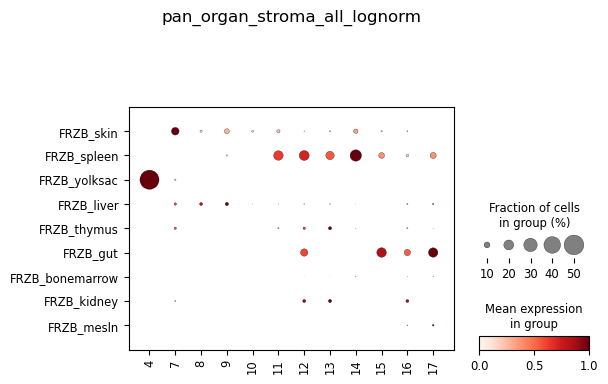

In [32]:
sc.pl.dotplot(pdata_all, var_names=['FRZB_skin', 'FRZB_spleen', 'FRZB_yolksac', 'FRZB_liver',
                               'FRZB_thymus', 'FRZB_gut', 'FRZB_bonemarrow', 'FRZB_kidney', 'FRZB_mesln'], 
              groupby='pcw_cat', standard_scale='var', swap_axes=True, title='pan_organ_stroma_all_lognorm')

#sc.pl.dotplot(pdata_all, var_names=['FRZB_skin', 'FRZB_spleen', 'FRZB_yolksac', 'FRZB_liver',
#                               'FRZB_thymus', 'FRZB_gut', 'FRZB_bonemarrow', 'FRZB_kidney', 'FRZB_mesln'], 
#              groupby='pcw_cat', standard_scale='var', swap_axes=True, title='pan_organ_stroma_all_lognorm', 
#              return_fig=True).savefig('/home/jovyan/projects/skin/fetal_skin/figures/marker_panels/figures_28042023/pan-immune_stroma_all_28042023.pdf')

In [33]:
keep2=['FIBROBLAST_I', 'FIBROBLAST_II', 'FIBROBLAST_III', 'FIBROBLAST_IV', 'FIBROBLAST_V', 
      'FIBROBLAST_VI', 'FIBROBLAST_VII', 'FIBROBLAST_VIII', 'FIBROBLAST_IX', 'FIBROBLAST_X', 'FIBROBLAST_XI', 'FIBROBLAST_XII',  
      'FIBROBLAST_XIII', 'FIBROBLAST_XIV', 'FIBROBLAST_XV', 'FIBROBLAST_XVI', 
      'CYCLING_FIBROBLAST_I', 'CYCLING_FIBROBLAST_II', 
      'MYOFIBROBLAST', 'MYOFIBROBLAST_I']

In [34]:
pdata_subset2 = pdata_all[pdata_all.obs['anno_lvl_2_final_clean'].isin(keep2)]

In [35]:
pdata_subset2

View of AnnData object with n_obs × n_vars = 185913 × 33546
    obs: 'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation', 'pcw_cat'
    obsm: 'X_scvi', 'X_umap'

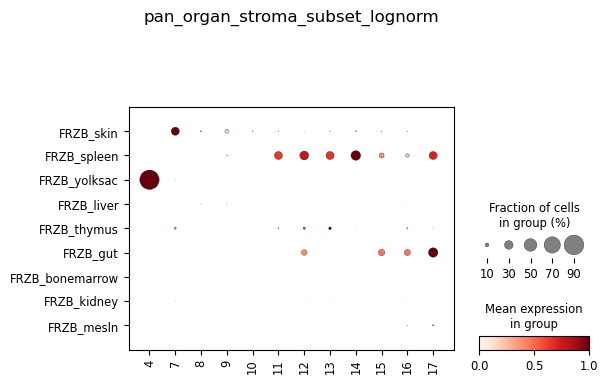

In [36]:
sc.pl.dotplot(pdata_subset2, var_names=['FRZB_skin', 'FRZB_spleen', 'FRZB_yolksac', 'FRZB_liver',
                               'FRZB_thymus', 'FRZB_gut', 'FRZB_bonemarrow', 'FRZB_kidney', 'FRZB_mesln'], 
              groupby='pcw_cat', standard_scale='var', swap_axes=True, title='pan_organ_stroma_subset_lognorm')

#sc.pl.dotplot(pdata_subset2, var_names=['FRZB_skin', 'FRZB_spleen', 'FRZB_yolksac', 'FRZB_liver',
#                               'FRZB_thymus', 'FRZB_gut', 'FRZB_bonemarrow', 'FRZB_kidney', 'FRZB_mesln'], 
#              groupby='pcw_cat', standard_scale='var', swap_axes=True, title='pan_organ_stroma_subset_lognorm', 
#              return_fig=True).savefig('/home/jovyan/projects/skin/fetal_skin/figures/marker_panels/figures_28042023/pan-immune_stroma_fibonly_28042023.pdf')